In [1]:
from analysis import *

%matplotlib inline

# Set style for all plots
sns.set_style("whitegrid")
plt.style.use('seaborn')


/var/folders/13/81m8_c8s5x3dwyxpg6hc69nw0000gn/T/ipykernel_4333/1484485703.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 1. parallelization speedup ~ throughput (episodes/fixed time budget) ~ playing strength (win rate, Elo)

<Figure size 1500x1000 with 0 Axes>

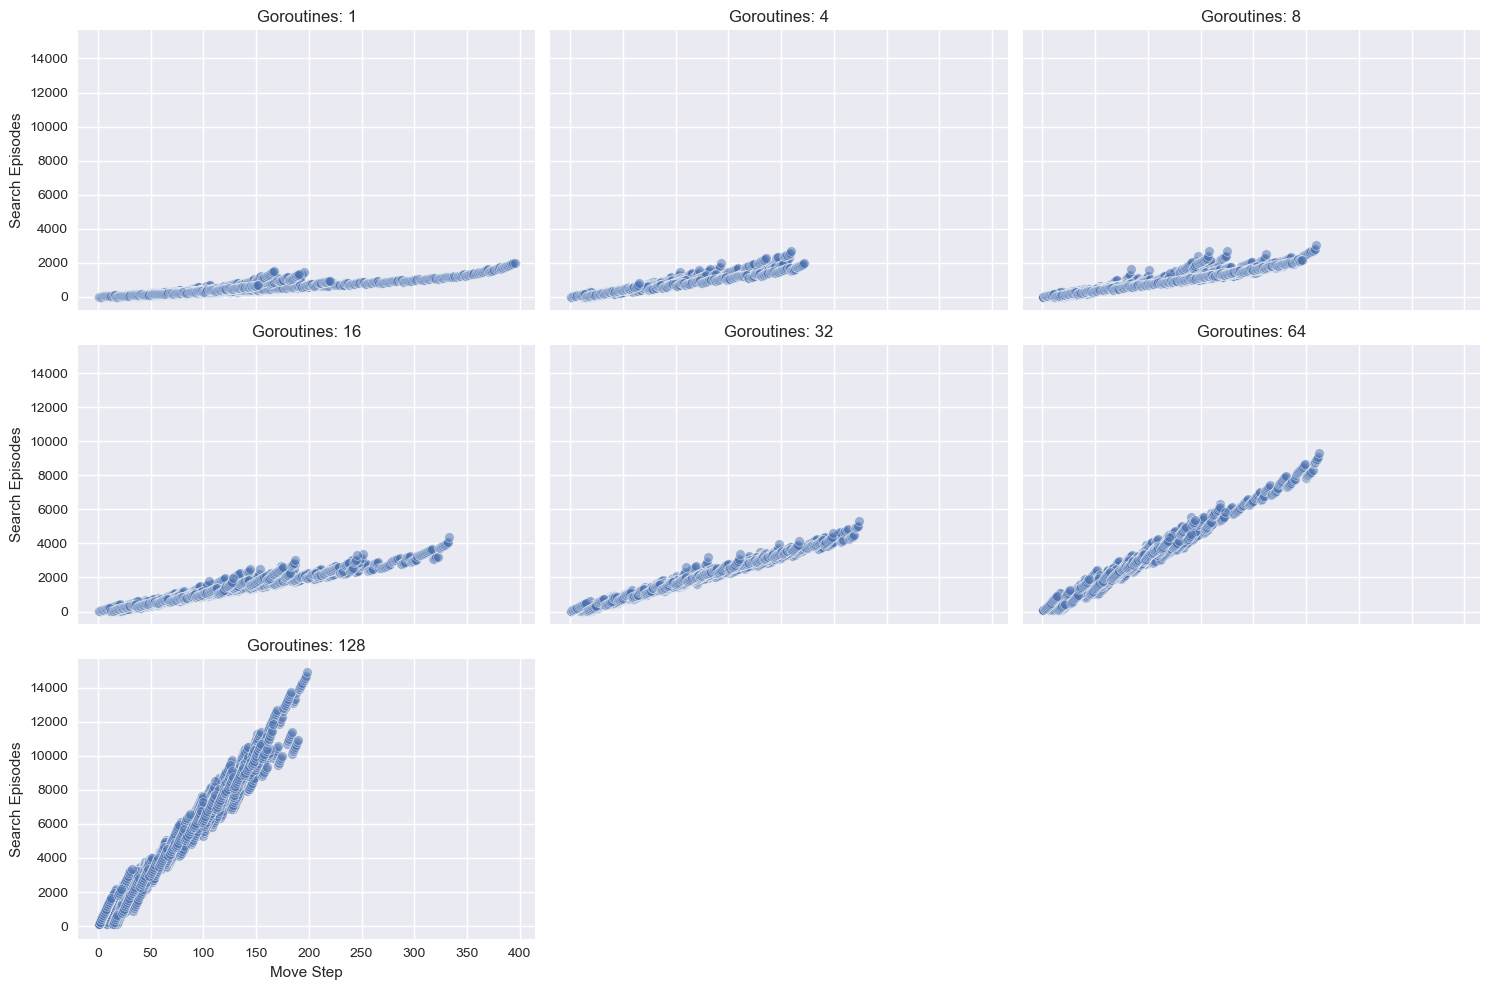

In [2]:
# Load experiment data
# TODO: use same experiment setup as strength experiment (diff concurrency levels parallel agents vs baseline)
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/parallelization_to_throughput")

# Generate plots
# TODO: smaller dot
plt = plot_episodes_by_step(move_records, agent_configs, output_dir)
plt.show()

- environment: 8-core CPU (4 performance cores + 4 efficiency cores)
- concurrency level increase (x4) -> episodes increase both earlier in game and in volume
- full playouts (no cutoff) > faster playouts/more episodes as game progresses/deeper into game

<Figure size 1500x1000 with 0 Axes>

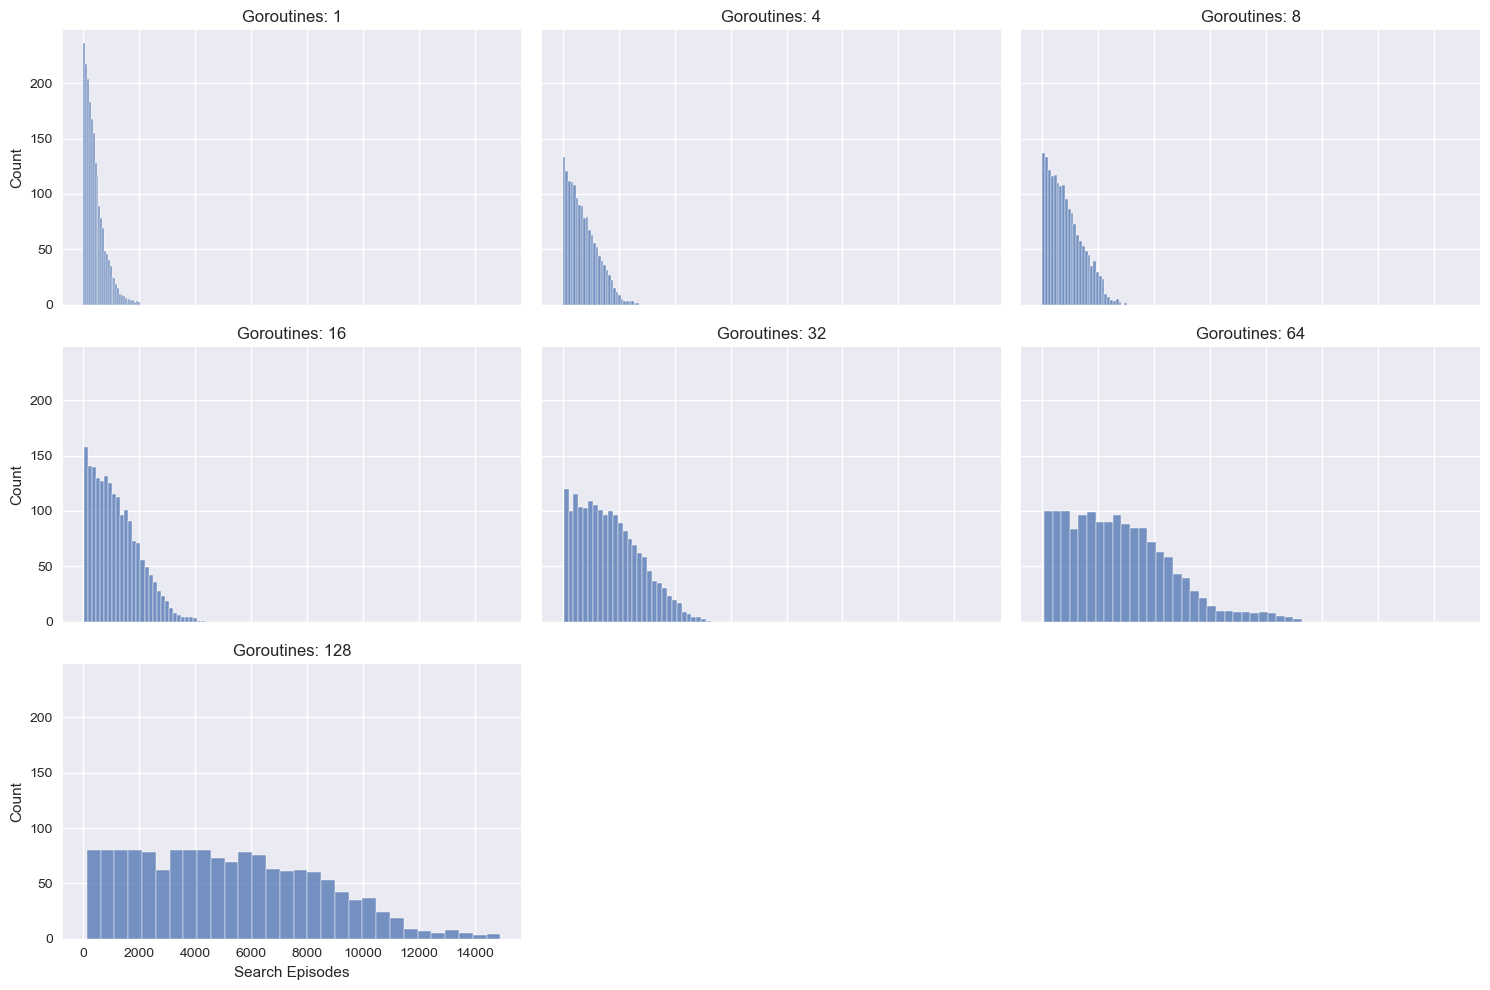

In [3]:
plt = plot_episodes_histogram(move_records, agent_configs, output_dir)
plt.show()

- all power law distribution (most searches have few episodes) > use box plot
- concurrency level increase -> more searchers with more episodes 

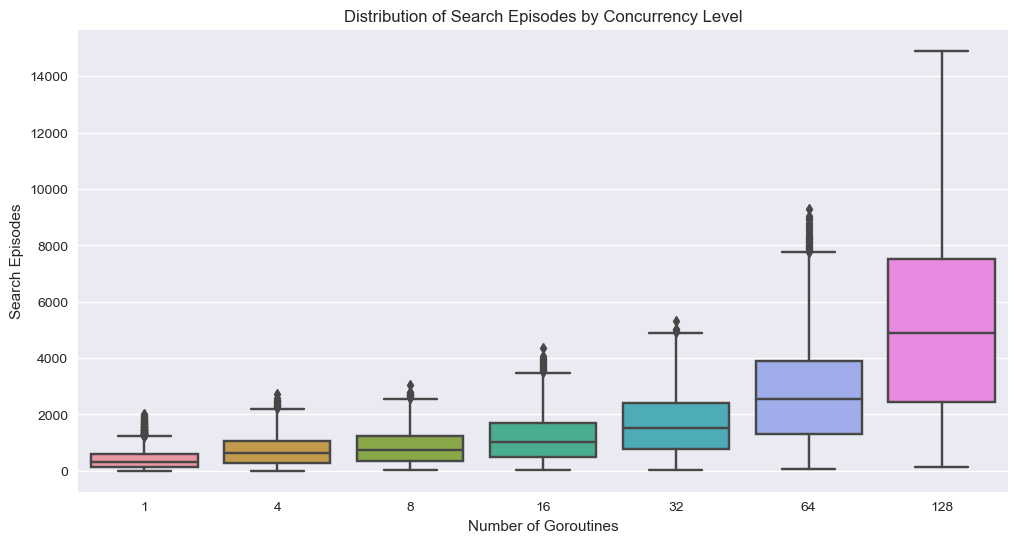


Summary Statistics by Concurrency Level:
                   mean          std  min    max
goroutines                                      
1            415.927803   353.617967    3   2018
4            723.472812   529.517543    9   2712
8            848.904433   605.810198   11   3032
16          1167.158198   822.440897   16   4360
32          1669.046179  1098.803035   32   5306
64          2750.689180  1848.535390   64   9290
128         5148.549230  3211.785041  128  14905


In [4]:
# TODO: or violin plot?
plt = plot_episodes_boxplot(move_records, agent_configs, output_dir)
plt.show()

# Print summary statistics
print("\nSummary Statistics by Concurrency Level:")
summary = move_records.groupby('goroutines')['episodes'].agg(['mean', 'std', 'min', 'max'])
print(summary)

- higher concurrency level -> more episodes
- not much diff between 4 and 8: why?

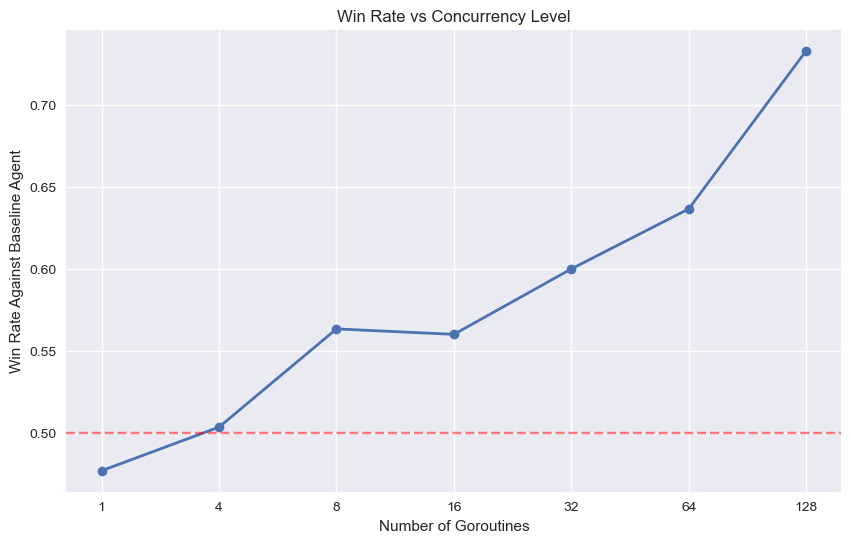


Win Rates vs Baseline Agent:
   goroutines  win_rate
0           1  0.476667
1           4  0.503333
2           8  0.563333
3          16  0.560000
4          32  0.600000
5          64  0.636667
6         128  0.733333


In [5]:
# Load experiment data
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/parallelization_to_strength")

# Calculate and plot win rates
win_rates = calculate_win_rates(game_records, agent_configs)
# TODO: write number of games played
plt = plot_win_rates(win_rates, output_dir)
plt.show()

print("\nWin Rates vs Baseline Agent:")
print(win_rates)


- baseline agent vs 1-goroutine agent win rate not 0.5??
- should see steady climb in win rate as concurrency level increases
- win rate reflects relative playing strength against baseline agent 
- elo rating reflects relative playing strength against all other agents 
=> should show similar trend: higher concurrency > more episodes per time budget > greater playing strength > higher win rate & Elo rating

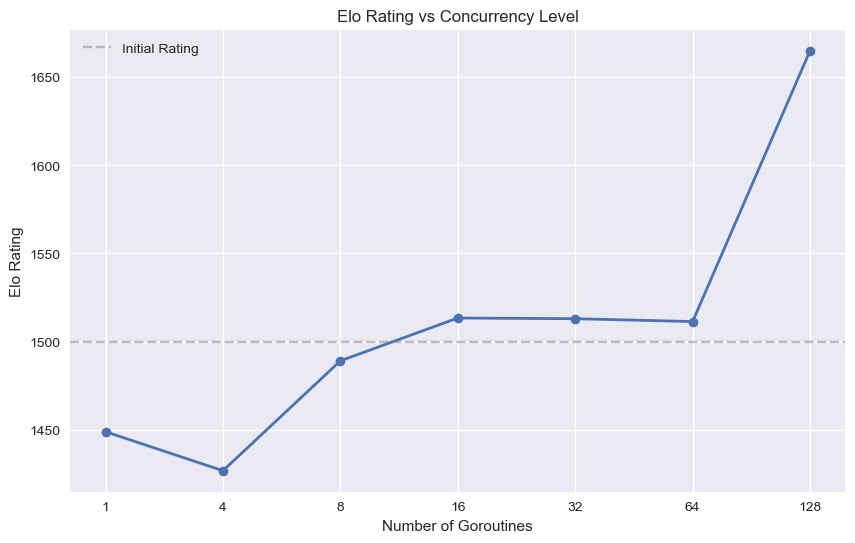


Elo Ratings:
        rating
0  1432.471029
1  1448.884420
2  1426.754312
3  1489.075566
4  1513.405512
5  1512.993219
6  1511.382834
7  1665.033108


In [19]:
# Calculate and plot Elo ratings
# TODO: draw randomized pairs of agents OR round-robin each unique pair of agents to play 10 or 30 games 
# TODO: alternate OR randomize starting agent
# TODO: plot and verify Elo ratings stabilize/converge after a sufficient number of games
# TODO: K = 32 if 10 games each, K = 16 if 30 games each
elo_ratings = calculate_elo_ratings(game_records)
# TODO: initial rating not important no need to show?
plt = plot_elo_ratings(elo_ratings, agent_configs, output_dir)
plt.show()

print("\nElo Ratings:")
ratings_df = pd.DataFrame.from_dict(elo_ratings, orient='index', columns=['rating'])
print(ratings_df.sort_index())



- don't show baseline agent rating: more games played > drags rating down to below 1-goroutine agent's (despite 0.5 win rate)
- should reflect similar trend as win rate

In [7]:
# TODO: to potentially explain irregularities in results:
# TODO: plot # of full playouts out of (vs) # of episodes per step across per matchup games, then analyze and explain 
# TODO: plot # of tree resets per step across per matchup games, then analyze and explain


# 2. cutoff depth ~ throughput (episodes/time budget) ~ playing strength (win rate)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   agent2  games  wins  win_rate  id  goroutines duration  episodes  \
1       2     30    26  0.866667   2           8     10ms         0   
2       3     30    18  0.600000   3           8     10ms         0   
3       4     30    15  0.500000   4           8     10ms         0   
4       5     30    14  0.466667   5           8     10ms         0   
0       1     30    14  0.466667   1           8     10ms         0   

                     cutoff evaluation  
1                       10           .  
2       75 (Lower Quartile)          .  
3              150 (Median)          .  
4      200 (Upper Quartile)          .  
0  Full Playout (No Cutoff)          .  


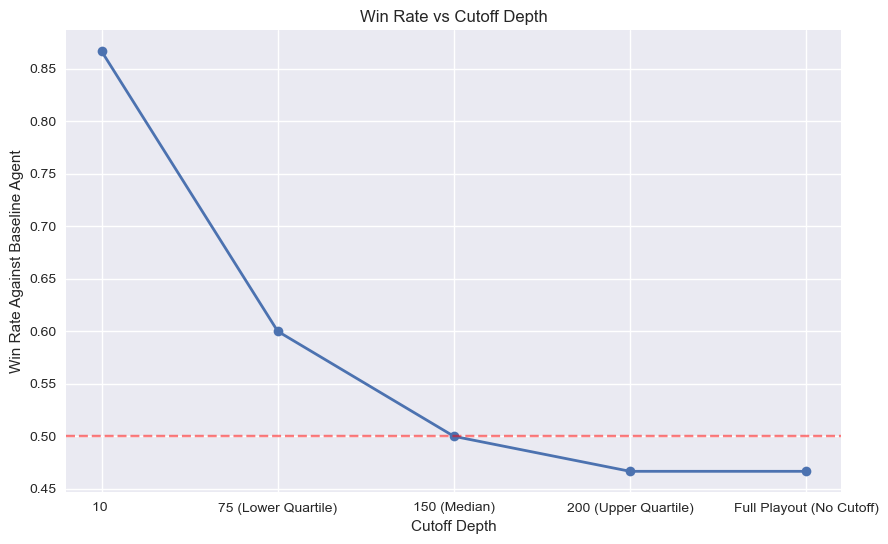

In [2]:
# TODO: plot game length (# of moves) vs parallel agent 
# TODO: 1) scatter plot: data points 
# TODO: 2) box plot: distribution 
# TODO: 3) line plot: mean + std

# experiment setup: pick 1 parallel agent (e.g. 16-goroutine, full playout) as new baseline, vary cutoff depth {10 or lower fence, lower quartile, median, upper quartile, full playout} while keeping other parameters constant (5 matchups), compare win rate and Elo rating 
# hypothesis: lower cutoff depth -> faster playouts -> more episodes (fixed time budget) -> discover more possible paths -> more robust stats -> more skilled agent -> higher win rate ASSUMING evaluation function estimates outcome well
# explanations: random full playout does not closely emulate real/intelligent game plays, good evaluation function may provide better outcome estimates, while faster rollouts allow more episodes within the same time budget
# future work: findings/lessons learned here (to improve playing strength) transferrable to other agents (other currency levels, after tailoring cutoff depth according to its game length distribution)
# optional: each/best agent in the cutoff depth experiment group plays 100 games against the sequential baseline, compare difference in win rates via statistical tests? (no added value)
# *ANOVA* determines whether *3 or more groups'* means are statistically significantly different/unequal (N/A). *t-test* determines whether *2 groups'* means OR *1 group's mean vs a fixed value* are statistically significantly different/larger/smaller (N/A).

# DONE: calculate and plot experiment agents' win rates
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/cutoff")

win_rates = calculate_win_rates(game_records, agent_configs)

# Order by cutoff depth for plotting
win_rates = win_rates.sort_values("cutoff")
# Get no cutoff (full playout) row
full_playout = win_rates.iloc[0:1].copy()
full_playout["cutoff"] = 'Full Playout (No Cutoff)'
# Process remaining cutoff depth rows
cutoff_depths = win_rates.iloc[1:].copy() 
label_postfixes = ['', '(Lower Quartile)', '(Median)', '(Upper Quartile)', '(Upper Fence)']
cutoff_depths['cutoff'] = [f"{depth} {label_postfixes[i]}" for i, depth in enumerate(cutoff_depths['cutoff'])]
# Combine and display results
win_rates = pd.concat([cutoff_depths, full_playout])
print(win_rates)

plt = plot_win_rates(
    win_rates,
    param_col="cutoff", 
    output_dir=output_dir,
    title="Win Rate vs Cutoff Depth",
    xlabel="Cutoff Depth"
)
plt.show()

# TODO: calculate and plot experiment agents' throughput distribution (episodes/time budget) in the same format as concurrency experiment
# TODO: potentially 1) calculate the correlation coefficient 2) show the correlation (2 lines in one chart) between throughput and win rate

# 3. evaluation function ~ outcome estimate quality ~ playing strength (win rate, Elo?)
 

In [9]:
# TODO: alternative: same setup as experiment 2, but each experiment group agent uses border strength evaluation = plot another line in win rate + Elo rating (5 matchups)
# hypothesis: border strength evaluation is better than resources evaluation and the effect may be bigger when cutoff depth is smaller 
# TODO: then final experiment: experiment 2 experiment group agents vs experiment 3 experiment group agents (5 matchups) => win rate + Elo rating to corroborate findings

# TODO: same setup could be extened with an agent that uses value network predictions as evaluation result to evaluate value network (future work)

agent_configs, game_records, move_records, output_dir = load_experiment_data("data/evaluation")

win_rates = calculate_win_rates(game_records, agent_configs)

plt = plot_win_rates(
    win_rates,
    param_col="evaluation", 
    output_dir=output_dir,
    title="Win Rate vs Evaluation Function",
    xlabel="Evaluation Function"
)
plt.show()

# 4. corroborate findings > Elo ratings
setup: sequential agent, 8-goroutine agent, parallel agent + cutoff, parallel agent + cutoff + border strength evaluation > round-robin 30 games each, alternating start > update Elo ratings in random order till convergence > relative playing strength (should show upwards trend)